# Digit Recognition Model Trainer

A convolutional neural network for identifying the digits 1-9. Used for recognizing the numbers in games of sudoku. 
<br/> (Zero was excluded since it is not used in sudoku)

* Author: Cameron Kinsella
* Dataset: MNIST
* Framework: PyTorch

---
## Building the Model

### Imports and constants

In [1]:

from typing import Dict
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

from ax.service.managed_loop import optimize

# Customized from the Ax package to allow plots to be saved as static images
from contour import plot_contour
from trace import optimization_trace_single_method


epochs = 5
dtype = torch.float

### Setting up the Dataset

In [2]:
# Values for Normalize() are the global mean and
# standard deviation of the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

train_data = datasets.MNIST('dataset/', train=True, download=True,
                            transform=transform)

test_data = datasets.MNIST('dataset/', train=False, download=True,
                           transform=transform)

In [3]:
def get_indices(dataset, class_name):
    indices = []
    for i in range(len(dataset.targets)):
        if dataset.targets[i] != class_name:
            indices.append(i)
    return indices


train_idx = get_indices(train_data, 0)
test_idx = get_indices(test_data, 0)

train_loader = DataLoader(train_data,
                          batch_size=64,
                          sampler=SubsetRandomSampler(train_idx))

test_loader = DataLoader(test_data,
                         batch_size=1000,
                         sampler=SubsetRandomSampler(test_idx))

### Defining the Neural Network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.dropout = nn.Dropout()  # Dropout to prevent overfitting
        self.fc1 = nn.Linear(7 * 7 * 128, 256)
        self.fc2 = nn.Linear(256, 10)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.softmax(out)

        return out

Selecting the device (GPU if available)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


---
## Optimizing the Model

In [6]:
# Loss function
criterion = nn.CrossEntropyLoss()

### Model Tester Function

In [7]:
def test(net: torch.nn.Module,
         test_loss_list: list,
         print_result: bool) -> float:

    correct, total, test_loss = 0, 0, 0
    # Turn off gradients to speed it up
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)

            # Note: Outputs of the network are log-probabilities
            # Checking answer
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            test_loss += criterion(output, labels).item()

    test_loss /= len(test_loader.dataset)
    test_loss_list.append(test_loss)

    if print_result:
        print('Images Tested =', total)
        print('Accuracy = {:.2f}%\n'.format(100. * correct / total))

    return correct / total

### Model Trainer Function

In [8]:
def train(net: torch.nn.Module,
          train_loss_list: list,
          train_count_list: list,
          test_loss_list: list,
          print_result: bool,
          num_epochs: int,
          params: Dict[str, float]) -> nn.Module:

    # Initialize network
    net.to(dtype=dtype, device=device)
    net.train()
    # Define loss and optimizer
    optimizer = optim.SGD(
        net.parameters(),
        lr=params.get("lr", 0.001),
        momentum=params.get("momentum", 0.9),
        weight_decay=params.get("weight_decay", 0.0))

    scheduler = optim.lr_scheduler.StepLR(
        optimizer,
        step_size=int(params.get("step_size", 30)),
        gamma=params.get("gamma", 1.0))  # default is no learning rate decay

    for epoch in range(1, num_epochs + 1):
        running_loss = 0
        for idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Get loss
            output = net(images)
            loss = criterion(output, labels)
            # Forward, back, optimize
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            # append data every 10 mini-batches, print every 100 mini-batches
            if idx % 10 == 0:
                train_loss_list.append(loss.item())
                train_count_list.append((idx*64) + (epoch-1) *
                                        len(train_loader.dataset))
            if print_result and idx % 100 == 0:
                print('Epoch {} -> [{}/{} ({:.0f}%)] Loss: {:.6}'.format(
                    epoch, idx * len(images.to(device)),
                    len(train_loader.dataset),
                    100. * idx / len(train_loader),
                    running_loss/len(train_loader))
                )
        else:
            if print_result:
                print('\nEpoch {} end:\nLoss = {:.6}'.format(
                    epoch, running_loss/len(train_loader)))
            test(net, test_loss_list, print_result)

    return net

### Obtaining the Optimal Learning Rate and Momentum
Returns the mean success rate for a single epoch

In [9]:
def train_test(parameters):
    net = Net()
    net = train(net, [], [], [], False, num_epochs=1, params=parameters)
    return test(net, [], False)

Next, the function above is used to find the optimal hyperparameters through Bayesian Optimization.
<br/> This is serious overkill for such a simple CNN, but I thought it would be fun to implement 🙂

In [10]:
best_parameters, values, experiment, cnn = optimize(
    parameters=[
        {'name': 'lr', 'type': 'range', 'bounds': [1e-6, 0.9], 'log_scale': True},
        {'name': 'momentum', 'type': 'range', 'bounds': [0.0, 1.0]},
    ],
    evaluation_function=train_test,
    objective_name='accuracy',
    total_trials=10
)

[INFO 03-01 01:42:30] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 03-01 01:42:30] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 03-01 01:42:30] ax.service.managed_loop: Running optimization trial 1...
[INFO 03-01 01:42:51] ax.service.managed_loop: Running optimization trial 2...
[INFO 03-01 01:43:09] ax.service.managed_loop: Running optimization trial 3...
[INFO 03-01 01:43:26] ax.service.managed_loop: Running optimization trial 4...
[INFO 03-01 01:43:43] ax.service.managed_loop: Running optimization trial 5...
[INFO 03-01 01:44:01] ax.service.managed_loop: Running optimization trial 6...
[INFO 03-01 01:44:19] ax.service.managed_loop: Running optimization trial 7...
[INFO 03-01 01:44:38] ax.service.managed_loop: Running optimization t

Best parameters, the arm from which they came, and their outcomes

In [11]:
best_parameters

{'lr': 0.03207506259806404, 'momentum': 0.46883466839790344}

In [12]:
means, covariances = values
means, covariances

({'accuracy': 0.9824833195831653},
 {'accuracy': {'accuracy': 1.5913464913217062e-08}})

In [13]:
data = experiment.fetch_data()
df = data.df
best_arm_name = df.arm_name[df['mean'] == df['mean'].max()].values[0]
best_arm = experiment.arms_by_name[best_arm_name]
best_arm

Arm(name='3_0', parameters={'lr': 0.03207506259806404, 'momentum': 0.46883466839790344})

Contour plot showing classification accuracy as a function of the two hyperparameters

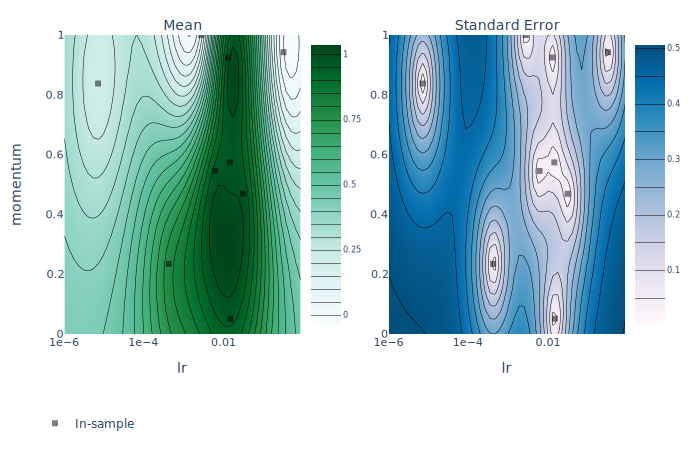

In [14]:
fig = plot_contour(model=cnn, param_x='lr', param_y='momentum', metric_name='accuracy')
fig.show('svg')

Plot demonstrating how the model accuracy improved as we identified better hyperparameters

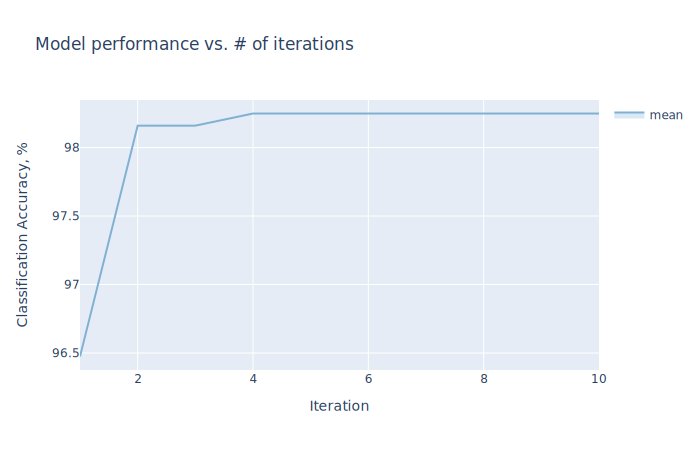

In [15]:
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])
best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title='Model performance vs. # of iterations',
    ylabel='Classification Accuracy, %'
)

best_objective_plot.show('svg')

---
## Training and Testing the Model With the Optimal Hyperparameters

In [16]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(epochs + 1)]

print('Initial test (no training):')
test(Net().to(device), test_losses, print_result=True)

model = train(net=Net(),
              train_loss_list=train_losses,
              train_count_list=train_counter,
              test_loss_list=test_losses,
              print_result=True,
              num_epochs=epochs,
              params=best_arm.parameters)

Initial test (no training):
Images Tested = 9020
Accuracy = 8.99%

Epoch 1 -> [0/60000 (0%)] Loss: 0.00275453
Epoch 1 -> [6400/60000 (12%)] Loss: 0.0688691
Epoch 1 -> [12800/60000 (24%)] Loss: 0.0897176
Epoch 1 -> [19200/60000 (36%)] Loss: 0.107869
Epoch 1 -> [25600/60000 (47%)] Loss: 0.123328
Epoch 1 -> [32000/60000 (59%)] Loss: 0.135158
Epoch 1 -> [38400/60000 (71%)] Loss: 0.146175
Epoch 1 -> [44800/60000 (83%)] Loss: 0.1576
Epoch 1 -> [51200/60000 (95%)] Loss: 0.167841

Epoch 1 end:
Loss = 0.172791
Images Tested = 9020
Accuracy = 97.96%

Epoch 2 -> [0/60000 (0%)] Loss: 5.42368e-05
Epoch 2 -> [6400/60000 (12%)] Loss: 0.00892569
Epoch 2 -> [12800/60000 (24%)] Loss: 0.0165857
Epoch 2 -> [19200/60000 (36%)] Loss: 0.0252304
Epoch 2 -> [25600/60000 (47%)] Loss: 0.033076
Epoch 2 -> [32000/60000 (59%)] Loss: 0.0416589
Epoch 2 -> [38400/60000 (71%)] Loss: 0.0497294
Epoch 2 -> [44800/60000 (83%)] Loss: 0.0569999
Epoch 2 -> [51200/60000 (95%)] Loss: 0.0628813

Epoch 2 end:
Loss = 0.066631
Imag

### Saving the final model

In [17]:
torch.save(model.state_dict(), './results/model.pth')

---
## Evaluating the Model

Figure template for training and testing loss data

In [18]:

def view_figure():
    plt.figure(figsize=(10,5))
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')

In [19]:
# Figure template for view_prediction data
def prediction_figure(img, prob, pred):
    prob = prob.cpu().data.numpy().squeeze()
        
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.set_title('Predicted Digit = {}'.format(str(pred)))
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray_r')
    ax1.axis('off')
    ax2.bar(np.arange(10), prob[0])
    ax2.set_aspect(9)
    ax2.set_xticks(np.arange(1, 10))
    ax2.set_xticklabels(np.arange(1, 10))
    ax2.set_xlim(xmin=0)
    ax2.set_title('Class Probability')
    ax2.set_ylim(0, 1.1)
    plt.tight_layout()

Figure demonstrating a test with the final model, showing the probability of each number

In [20]:
# Function for viewing an example image and prediction
def view_prediction():
    images, labels = next(iter(test_loader))
    
    # Turn off gradients to speed up this part
    with torch.no_grad():
        output = model(images.to(device))
    
    # Convert the log-probability for checking probability of each class
    probability = torch.exp(output) 
    
    prediction = list(output.cpu().numpy()[0])
    prediction_figure(images, probability, prediction.index(max(prediction)))

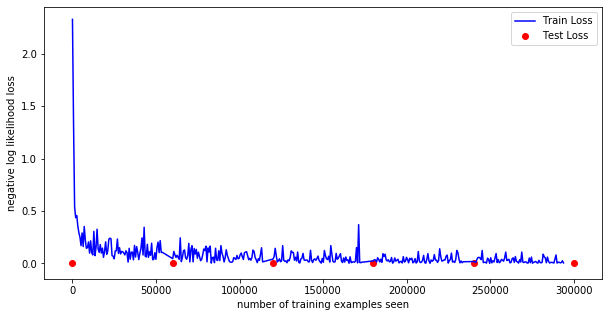

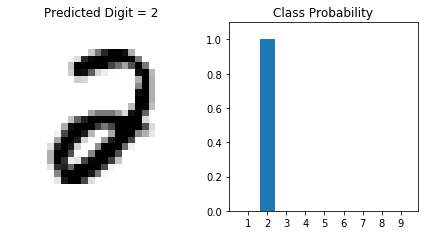

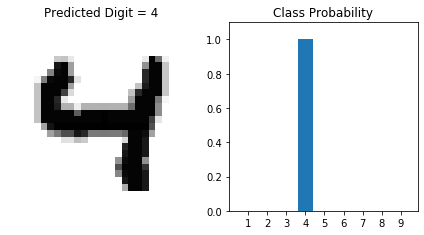

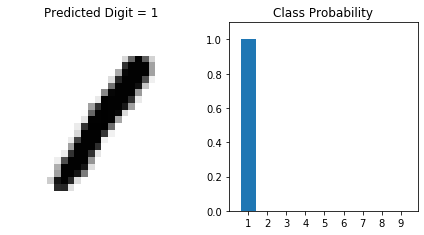

In [21]:
view_figure()
for i in range(3):
    view_prediction()